In [68]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [69]:
from rag.pdf import PDFRetrievalChain

### PDF 문서 검색 Retrieval Chain 생성

In [70]:
# PDF 문서를 로드
pdf = PDFRetrievalChain(['data/SPRI_AI_Brief_2023년12월호_F.pdf']).create_chain()

In [71]:
pdf_retriever = pdf.retriever       # retriever 생성

In [72]:
pdf_chain = pdf.chain               # pdf retriever chain 생성

### State 정의

`State`: Graph 의 노드와 노드들을 끼리 공유하는 상태를 정의합니다.
<br>

State에 관련성(relevance) 체크 결과를 추가합니다.

In [73]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

class GraphState(TypedDict):               
    question: Annotated[str, 'question']        # 질문
    context: Annotated[str, 'context']          # 문서의 검색 결과
    answer: Annotated[str, 'Answer']            # 답변
    messages: Annotated[list, add_messages ]    # 메시지
    relevance: Annotated[str, 'Relevance']      # 관련성

### 노드 정의

`Nodes`: 각 단계를 처리하는 노드입니다. Python 함수로 만들게 되고 함수의 입력과 출력이 상태(State) 값입니다. <br>

`State` 를 입력으로 받아 정의된 로직을 수행한 후 업데이트된 State를 반환합니다.

In [74]:
from langchain_teddynote.messages import messages_to_history
from rag.utils import format_docs

In [75]:
from langchain_teddynote.evaluator import GroundednessChecker
from langchain_openai import ChatOpenAI

In [76]:
def retrieve_document(state: GraphState) -> GraphState:             # 문서 검색 노드 
    
    latest_question = state['question']                             # state 에서 질문(question)을 가져온다.
    
    retrieve_docs = pdf_retriever.invoke(latest_question)           # pdf_retriever를 사용해서 문서 검색하여 관련성 있는 문서를 찾습니다.
    retrieve_docs = format_docs(retrieve_docs)                      # 검색된 문서를 모두 문자열로 변경 (프롬프트의 입력이 된다)
    
    return {'context': retrieve_docs}                               

In [77]:
state = GraphState(
    question='삼성전자가 개발한 생성형 AI',
    context='',
    answer='',
    messages=[],
)

result1 = retrieve_document(state)
state['context'] = result1['context']

In [78]:
state

{'question': '삼성전자가 개발한 생성형 AI',
 'context': '<document><content>▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>2</page></document>\n<document><content>SPRi AI Brief |\n2023-12월호\n삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개\nKEY Contents\nn 삼성전자가 온디바이스에서 작동 가능하며 언어, 코드, 이미지의 3개 모델로 구성된 자체 개발 생성\nAI 모델 ‘삼성 가우스’를 공개\nn 삼성전자는 삼성 가우스를 다양한 제품에 단계적으로 탑재할 계획으로, 온디바이스 작동이 가능한\n삼성 가우스는 외부로 사용자 정보가 유출될 위험이 없다는 장점을 보유\n£언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>13</page></document>\n<document><content>어시스턴트를 적용한 구글 픽셀(Pixel)과 경쟁할 것으로 예상\n☞ 출처 : 삼성전자, ‘삼성 AI 포럼’서 자체 개발 생성형 AI ‘삼성 가우스’ 공개, 2023.11.08.\n삼성전자, ‘삼성 개발자 콘퍼런스 코리아 2023’ 개최, 2023.11.14.\nTechRepublic, Sa

In [79]:
def llm_answer(state: GraphState) -> GraphState:
    
    latest_question = state['question']                             # state 에서 질문(question)을 가져온다.
    context = state['context']                                      # state 에서 검색된 문서의 내용(context)을 가져온다.
    
    response = pdf_chain.invoke(                                    # pdf_chain을 호출해서 대답을 만듭니다.
        {
            'question': latest_question,                            # 질문      
            'context': context,                                     # 검색된 문서의 내용
            'chat_history': messages_to_history(state['messages'])  
        }
    )

    return {                                                       
        'answer': response,                                                 # 생성된 답변을 answer에 저장
        'messages': [('user', latest_question), ('assistant', response)]    # user의 질문과 생성된 답변을 messages에 저장
    }

In [80]:
def relevance_check(state: GraphState) -> GraphState:                       # 관련성 평가 노드

    question_retrival_relevat = GroundednessChecker(                        # 관련성 평가기를 생성. 
        llm = ChatOpenAI(api_key=key, model_name='gpt-4o-mini'), 
        target='question-retrieval'                                         # 검색된 문서가 질문에 답변하기 위한 내용이 포함되어 있는지 체크하는 평가기.
    ).create()                                                              

    response = question_retrival_relevat.invoke(                            # 관련성 체크 실행 (yes or no)
        {'question': state['question'], 'context': state['context']}
    )

    return {"relevance": response.score}

In [81]:
relevance_check(state)

{'relevance': 'yes'}

In [82]:
def is_relevant(state: GraphState) -> GraphState:

    print(f"[관련성 평가 함수] ")
    
    if state['relevance']=='yes':
        print('relevant')
        return 'relevant'
    else:
        print('not relevant')
        return 'not relevant'

### 그래프 정의

`Edges`: 현재 State를 기반으로 다음에 실행할 Node를 결정하는 Python 함수.<br>

일반 엣지, 조건부 엣지 등이 있습니다.

In [83]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_teddynote.graphs import visualize_graph

In [84]:
######### 1. 그래프 생성 #########

workflow = StateGraph(GraphState)

In [85]:
######### 2. 노드 정의  #########

# 노드 이름, 함수 이름을 넣으서 노드를 추가
workflow.add_node('retrieve', retrieve_document)        # 문서 검색 노드
workflow.add_node('llm_answer', llm_answer)             # 답변 생성 노드

workflow.add_node("relevance_check", relevance_check)   # 관련성 체크 노드 추가

In [86]:
######### 3. 그래프 엣지(Edge) 추가  #########

workflow.add_edge('retrieve', 'relevance_check')        # 검색(retrieve) 에서 관련성 체크

workflow.add_conditional_edges(                         # 조건부 엣지
    'relevance_check',                                  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달
    is_relevant,                                        # 분기 함수(yse: relevant, no: not relevant)
    {
        'relevant': 'llm_answer',                       # 관련성이 있으면 답변을 생성합니다. llm_answer 실행
        'not relevant': 'retrieve',                     # 관련성이 없으면 다시 검색합니다.   retrieve 실행
    },
)

workflow.add_edge('llm_answer', END)                    # 답변(llm_answer) 에서 종료(END)

In [87]:
######### 4. 그래프 진입점  #########

workflow.set_entry_point('retrieve')

In [88]:
######### 5. 체크 포인터 설정  #########

memory = MemorySaver()

In [89]:
######### 6. 그래프 컴파일(compile)  #########

app = workflow.compile(checkpointer=memory)

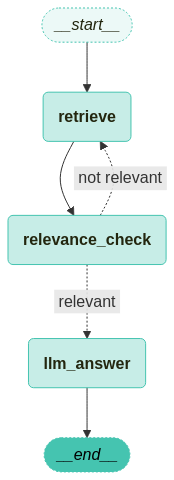

In [90]:
visualize_graph(app)

### 그래프 실행

- `config` 파라미터는 그래프 실행 시 필요한 정보를 전달.

    - `recursion_limit`: 그래프 실행 시 노드 반복의 횟수를 설정.
    - `thread_id`: 대화 세션을 구분하는 데 사용. 

<br>

- `inputs`: 그래프 실행 시 필요한 입력정보를 전달.

In [91]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid

In [92]:
config = RunnableConfig(                        # config 설정
    recursion_limit=10,                         # 최대 10개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

# 질문
inputs = GraphState(question='앤스로픽에 투자한 기업과 투자금액을 알려주세요.')


i = 1

for chunk in app.stream(inputs, config=config, stream_mode="updates"):
    print(f"===== for 시작 {i} =====")

    j = 1

    for state_key, state_value in chunk.items():
        print(f"== for 시작 {i} - {j} ==")
        print(f"state_key : {state_key }")
        print(f"state_value: \n {state_value}")
        print(f"== for  끝 {i} - {j}==")

        j=j+1
    
    print(f"===== for 끝 {i} =====")
    i=i+1

===== for 시작 1 =====
== for 시작 1 - 1 ==
state_key : retrieve
state_value: 
 {'context': '<document><content>1. 정책/법제 2. 기업/산업 3. 기술/연구 4. 인력/교육\n구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화\nKEY Contents\nn 구글이 앤스로픽에 최대 20억 달러 투자에 합의하고 5억 달러를 우선 투자했으며, 앤스로픽은\n구글과 클라우드 서비스 사용 계약도 체결\nn 3대 클라우드 사업자인 구글, 마이크로소프트, 아마존은 차세대 AI 모델의 대표 기업인\n앤스로픽 및 오픈AI와 협력을 확대하는 추세\n£구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>14</page></document>\n<document><content>£구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공\nn 구글이 2023년 10월 27일 앤스로픽에 최대 20억 달러를 투자하기로 합의했으며, 이 중 5억\n달러를 우선 투자하고 향후 15억 달러를 추가로 투자할 방침\n∙ 구글은 2023년 2월 앤스로픽에 이미 5억 5,000만 달러를 투자한 바 있으며, 아마존도 지난 9월\n앤스로픽에 최대 40억 달러의 투자 계획을 공개\n∙ 한편, 2023년 11월 8일 블룸버그 보도에 따르면 앤스로픽은 구글의 클라우드 서비스 사용을 위해\n4년간 30억 달러 규모의 계약을 체결</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>14</page></document>\n<document><content>4년간 30억 달러 규모의 계약을 체결\n∙ 오픈AI 창업자 그룹의 일원이었던 다리오(Dario Amodei)와 다니엘라 아모데이(Daniela Amodei)\n

In [93]:
config = RunnableConfig(                        # config 설정
    recursion_limit=10,                         # 최대 10개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

# 질문
inputs = GraphState(question='앤스로픽에 투자한 기업과 투자금액을 알려주세요.')

for chunk in app.stream(inputs, config=config, stream_mode="updates"):

    for state_key, state_value in chunk.items():
        if state_key == 'retrieve':
            print('------------------------------')
            print(f"🔄 [Node] 문서 검색 노드 🔄")
            print(f"{state_value['context']}")
            print('------------------------------')
        elif state_key == 'llm_answer':
            print('------------------------------')
            print(f"🔄 [Node] 답변 생성 노드 🔄")
            print(f"{state_value['answer']}")
            print('------------------------------')
        elif state_key == 'relevance_check':
            print('------------------------------')
            print(f"🔄 [Node] 관련성 체크 노드 🔄")
            print(f"{state_value['relevance']}")
            print('------------------------------')

------------------------------
🔄 [Node] 문서 검색 노드 🔄
<document><content>1. 정책/법제 2. 기업/산업 3. 기술/연구 4. 인력/교육
구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화
KEY Contents
n 구글이 앤스로픽에 최대 20억 달러 투자에 합의하고 5억 달러를 우선 투자했으며, 앤스로픽은
구글과 클라우드 서비스 사용 계약도 체결
n 3대 클라우드 사업자인 구글, 마이크로소프트, 아마존은 차세대 AI 모델의 대표 기업인
앤스로픽 및 오픈AI와 협력을 확대하는 추세
£구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>14</page></document>
<document><content>£구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공
n 구글이 2023년 10월 27일 앤스로픽에 최대 20억 달러를 투자하기로 합의했으며, 이 중 5억
달러를 우선 투자하고 향후 15억 달러를 추가로 투자할 방침
∙ 구글은 2023년 2월 앤스로픽에 이미 5억 5,000만 달러를 투자한 바 있으며, 아마존도 지난 9월
앤스로픽에 최대 40억 달러의 투자 계획을 공개
∙ 한편, 2023년 11월 8일 블룸버그 보도에 따르면 앤스로픽은 구글의 클라우드 서비스 사용을 위해
4년간 30억 달러 규모의 계약을 체결</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>14</page></document>
<document><content>4년간 30억 달러 규모의 계약을 체결
∙ 오픈AI 창업자 그룹의 일원이었던 다리오(Dario Amodei)와 다니엘라 아모데이(Daniela Amodei)
남매가 2021년 설립한 앤스로픽은 챗GPT의 대항마 ‘클로드(Claude)’ LLM을 개발
n 아

In [94]:
def invoke_graph_(graph=app, inputs=inputs, config=config):
    
    for chunk in app.stream(inputs, config=config, stream_mode="updates"):
        print(f"==" * 50)
        
        for state_key, state_value in chunk.items():
            if state_key == 'retrieve':
                print('------------------------------')
                print(f"🔄 [Node] 문서 검색 노드 🔄")
                print(f"{state_value['context']}")
                print('------------------------------')
            elif state_key == 'llm_answer':
                print('------------------------------')
                print(f"🔄 [Node] 답변 생성 노드 🔄")
                print(f"{state_value['answer']}")
                print('------------------------------')
            elif state_key == 'relevance_check':
                print('------------------------------')
                print(f"🔄 [Node] 관련성 체크 노드 🔄")
                print(f"{state_value['relevance']}")
                print('------------------------------')

        print(f"==" * 50)
        print()

In [95]:
config = RunnableConfig(                        # config 설정
    recursion_limit=10,                         # 최대 10개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

# 질문
inputs = GraphState(question='앤스로픽에 투자한 기업과 투자금액을 알려주세요.')
invoke_graph_(graph=app, inputs=inputs, config=config)

------------------------------
🔄 [Node] 문서 검색 노드 🔄
<document><content>1. 정책/법제 2. 기업/산업 3. 기술/연구 4. 인력/교육
구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화
KEY Contents
n 구글이 앤스로픽에 최대 20억 달러 투자에 합의하고 5억 달러를 우선 투자했으며, 앤스로픽은
구글과 클라우드 서비스 사용 계약도 체결
n 3대 클라우드 사업자인 구글, 마이크로소프트, 아마존은 차세대 AI 모델의 대표 기업인
앤스로픽 및 오픈AI와 협력을 확대하는 추세
£구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>14</page></document>
<document><content>£구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공
n 구글이 2023년 10월 27일 앤스로픽에 최대 20억 달러를 투자하기로 합의했으며, 이 중 5억
달러를 우선 투자하고 향후 15억 달러를 추가로 투자할 방침
∙ 구글은 2023년 2월 앤스로픽에 이미 5억 5,000만 달러를 투자한 바 있으며, 아마존도 지난 9월
앤스로픽에 최대 40억 달러의 투자 계획을 공개
∙ 한편, 2023년 11월 8일 블룸버그 보도에 따르면 앤스로픽은 구글의 클라우드 서비스 사용을 위해
4년간 30억 달러 규모의 계약을 체결</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>14</page></document>
<document><content>4년간 30억 달러 규모의 계약을 체결
∙ 오픈AI 창업자 그룹의 일원이었던 다리오(Dario Amodei)와 다니엘라 아모데이(Daniela Amodei)
남매가 2021년 설립한 앤스로픽은 챗GPT의 대항마 ‘클로드(Claude)’ LLM을 개발
n 아

In [96]:
import sys
import time

def stream_graph_(graph=app, inputs=inputs, config=config):
    for chunk in app.stream(inputs, config=config, stream_mode="updates"):
        print(f"==" * 50)

        for state_key, state_value in chunk.items():
            if state_key == 'retrieve':
                print('------------------------------')
                print(f"🔄 [Node] 문서 검색 노드 🔄")
                print(f"{state_value['context']}")
                print('------------------------------')
            elif state_key == 'llm_answer':
                print('------------------------------')
                print(f"🔄 [Node] 답변 생성 노드 🔄")
                print(f"{state_value['answer']}")

                for char in state_value['answer']:
                    sys.stdout.write(char)
                    sys.stdout.flush()
                    time.sleep(0.01)
                    
                print('------------------------------')
            elif state_key == 'relevance_check':
                print('------------------------------')
                print(f"🔄 [Node] 관련성 체크 노드 🔄")
                print(f"{state_value['relevance']}")
                print('------------------------------')

        print(f"==" * 50)
        print()

In [97]:
config = RunnableConfig(                        # config 설정
    recursion_limit=10,                         # 최대 10개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

# 질문
inputs = GraphState(question='앤스로픽에 투자한 기업과 투자금액을 알려주세요.')

stream_graph_(graph=app, inputs=inputs, config=config)

------------------------------
🔄 [Node] 문서 검색 노드 🔄
<document><content>1. 정책/법제 2. 기업/산업 3. 기술/연구 4. 인력/교육
구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화
KEY Contents
n 구글이 앤스로픽에 최대 20억 달러 투자에 합의하고 5억 달러를 우선 투자했으며, 앤스로픽은
구글과 클라우드 서비스 사용 계약도 체결
n 3대 클라우드 사업자인 구글, 마이크로소프트, 아마존은 차세대 AI 모델의 대표 기업인
앤스로픽 및 오픈AI와 협력을 확대하는 추세
£구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>14</page></document>
<document><content>£구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공
n 구글이 2023년 10월 27일 앤스로픽에 최대 20억 달러를 투자하기로 합의했으며, 이 중 5억
달러를 우선 투자하고 향후 15억 달러를 추가로 투자할 방침
∙ 구글은 2023년 2월 앤스로픽에 이미 5억 5,000만 달러를 투자한 바 있으며, 아마존도 지난 9월
앤스로픽에 최대 40억 달러의 투자 계획을 공개
∙ 한편, 2023년 11월 8일 블룸버그 보도에 따르면 앤스로픽은 구글의 클라우드 서비스 사용을 위해
4년간 30억 달러 규모의 계약을 체결</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>14</page></document>
<document><content>4년간 30억 달러 규모의 계약을 체결
∙ 오픈AI 창업자 그룹의 일원이었던 다리오(Dario Amodei)와 다니엘라 아모데이(Daniela Amodei)
남매가 2021년 설립한 앤스로픽은 챗GPT의 대항마 ‘클로드(Claude)’ LLM을 개발
n 아

In [98]:
invoke_graph(graph=app, inputs=inputs, config=config)


🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>1. 정책/법제 2. 기업/산업 3. 기술/연구 4. 인력/교육
구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화
KEY Contents
n 구글이 앤스로픽에 최대 20억 달러 투자에 합의하고 5억 달러를 우선 투자했으며, 앤스로픽은
구글과 클라우드 서비스 사용 계약도 체결
n 3대 클라우드 사업자인 구글, 마이크로소프트, 아마존은 차세대 AI 모델의 대표 기업인
앤스로픽 및 오픈AI와 협력을 확대하는 추세
£구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>14</page></document>
<document><content>£구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공
n 구글이 2023년 10월 27일 앤스로픽에 최대 20억 달러를 투자하기로 합의했으며, 이 중 5억
달러를 우선 투자하고 향후 15억 달러를 추가로 투자할 방침
∙ 구글은 2023년 2월 앤스로픽에 이미 5억 5,000만 달러를 투자한 바 있으며, 아마존도 지난 9월
앤스로픽에 최대 40억 달러의 투자 계획을 공개
∙ 한편, 2023년 11월 8일 블룸버그 보도에 따르면 앤스로픽은 구글의 클라우드 서비스 사용을 위해
4년간 30억 달러 규모의 계약을 체결</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>14</page></document>
<document><content>4년간 30억 달러 규모의 계약을 체결
∙ 오픈AI 창업자 그룹의 일원이었던 다리오(Dario Amodei)와 다니엘라 아모데이(Daniela Amodei)
남매가 2021년 설립한 앤스로픽은 챗GPT의 

In [99]:
stream_graph(graph=app, inputs=inputs, config=config)


🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"score":"yes"}[관련성 평가 함수] 
relevant

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
구글이 앤스로픽에 최대 20억 달러를 투자하기로 합의하고, 이 중 5억 달러를 우선 투자했습니다. 아마존은 앤스로픽에 최대 40억 달러의 투자 계획을 발표했습니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 14)